In [1]:
# %load my_imports.ipy
# Stdlib
from functools import partial
from pprint import pprint
from itertools import chain
from math import ceil

import numpy as np
import pandas as pd

pd.set_option('display.max_columns',102)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width',200)

import sklearn
import sklearn.linear_model
import sklearn.ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, StratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from genetic.estimator_params import params

# Visualization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

custom_style = {'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', }
sns.set_style( rc=custom_style)
mpl.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.figsize']=(10,10)
jtplot.style('monokai')
# Custom stuff
from swozny_ml import *
from genetic.param_opt import tune_params_genetic

# Config

In [2]:
filename = 'data.csv'
index = 'shot_id'
target = 'shot_made_flag'

In [3]:
# Read data
data = pd.read_csv(filename, index_col=index)
print(data.head())

               action_type combined_shot_type  game_event_id   game_id      lat  loc_x  loc_y       lon  minutes_remaining  period  playoffs   season  seconds_remaining  shot_distance  \
shot_id                                                                                                                                                                                   
1        Jump Shot          Jump Shot          10             20000012  33.9723  167    72    -118.1028  10                 1       0         2000-01  27                 18              
2        Jump Shot          Jump Shot          12             20000012  34.0443 -157    0     -118.4268  10                 1       0         2000-01  22                 15              
3        Jump Shot          Jump Shot          35             20000012  33.9093 -101    135   -118.3708  7                  1       0         2000-01  45                 16              
4        Jump Shot          Jump Shot          43             200

## Categorical

In [4]:
# Categorical
categorical = data.select_dtypes(exclude=[np.number])
for col in categorical:
    data[col]=data[col].astype('category')
categorical = data.select_dtypes(exclude=[np.number])
categorical.describe()

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


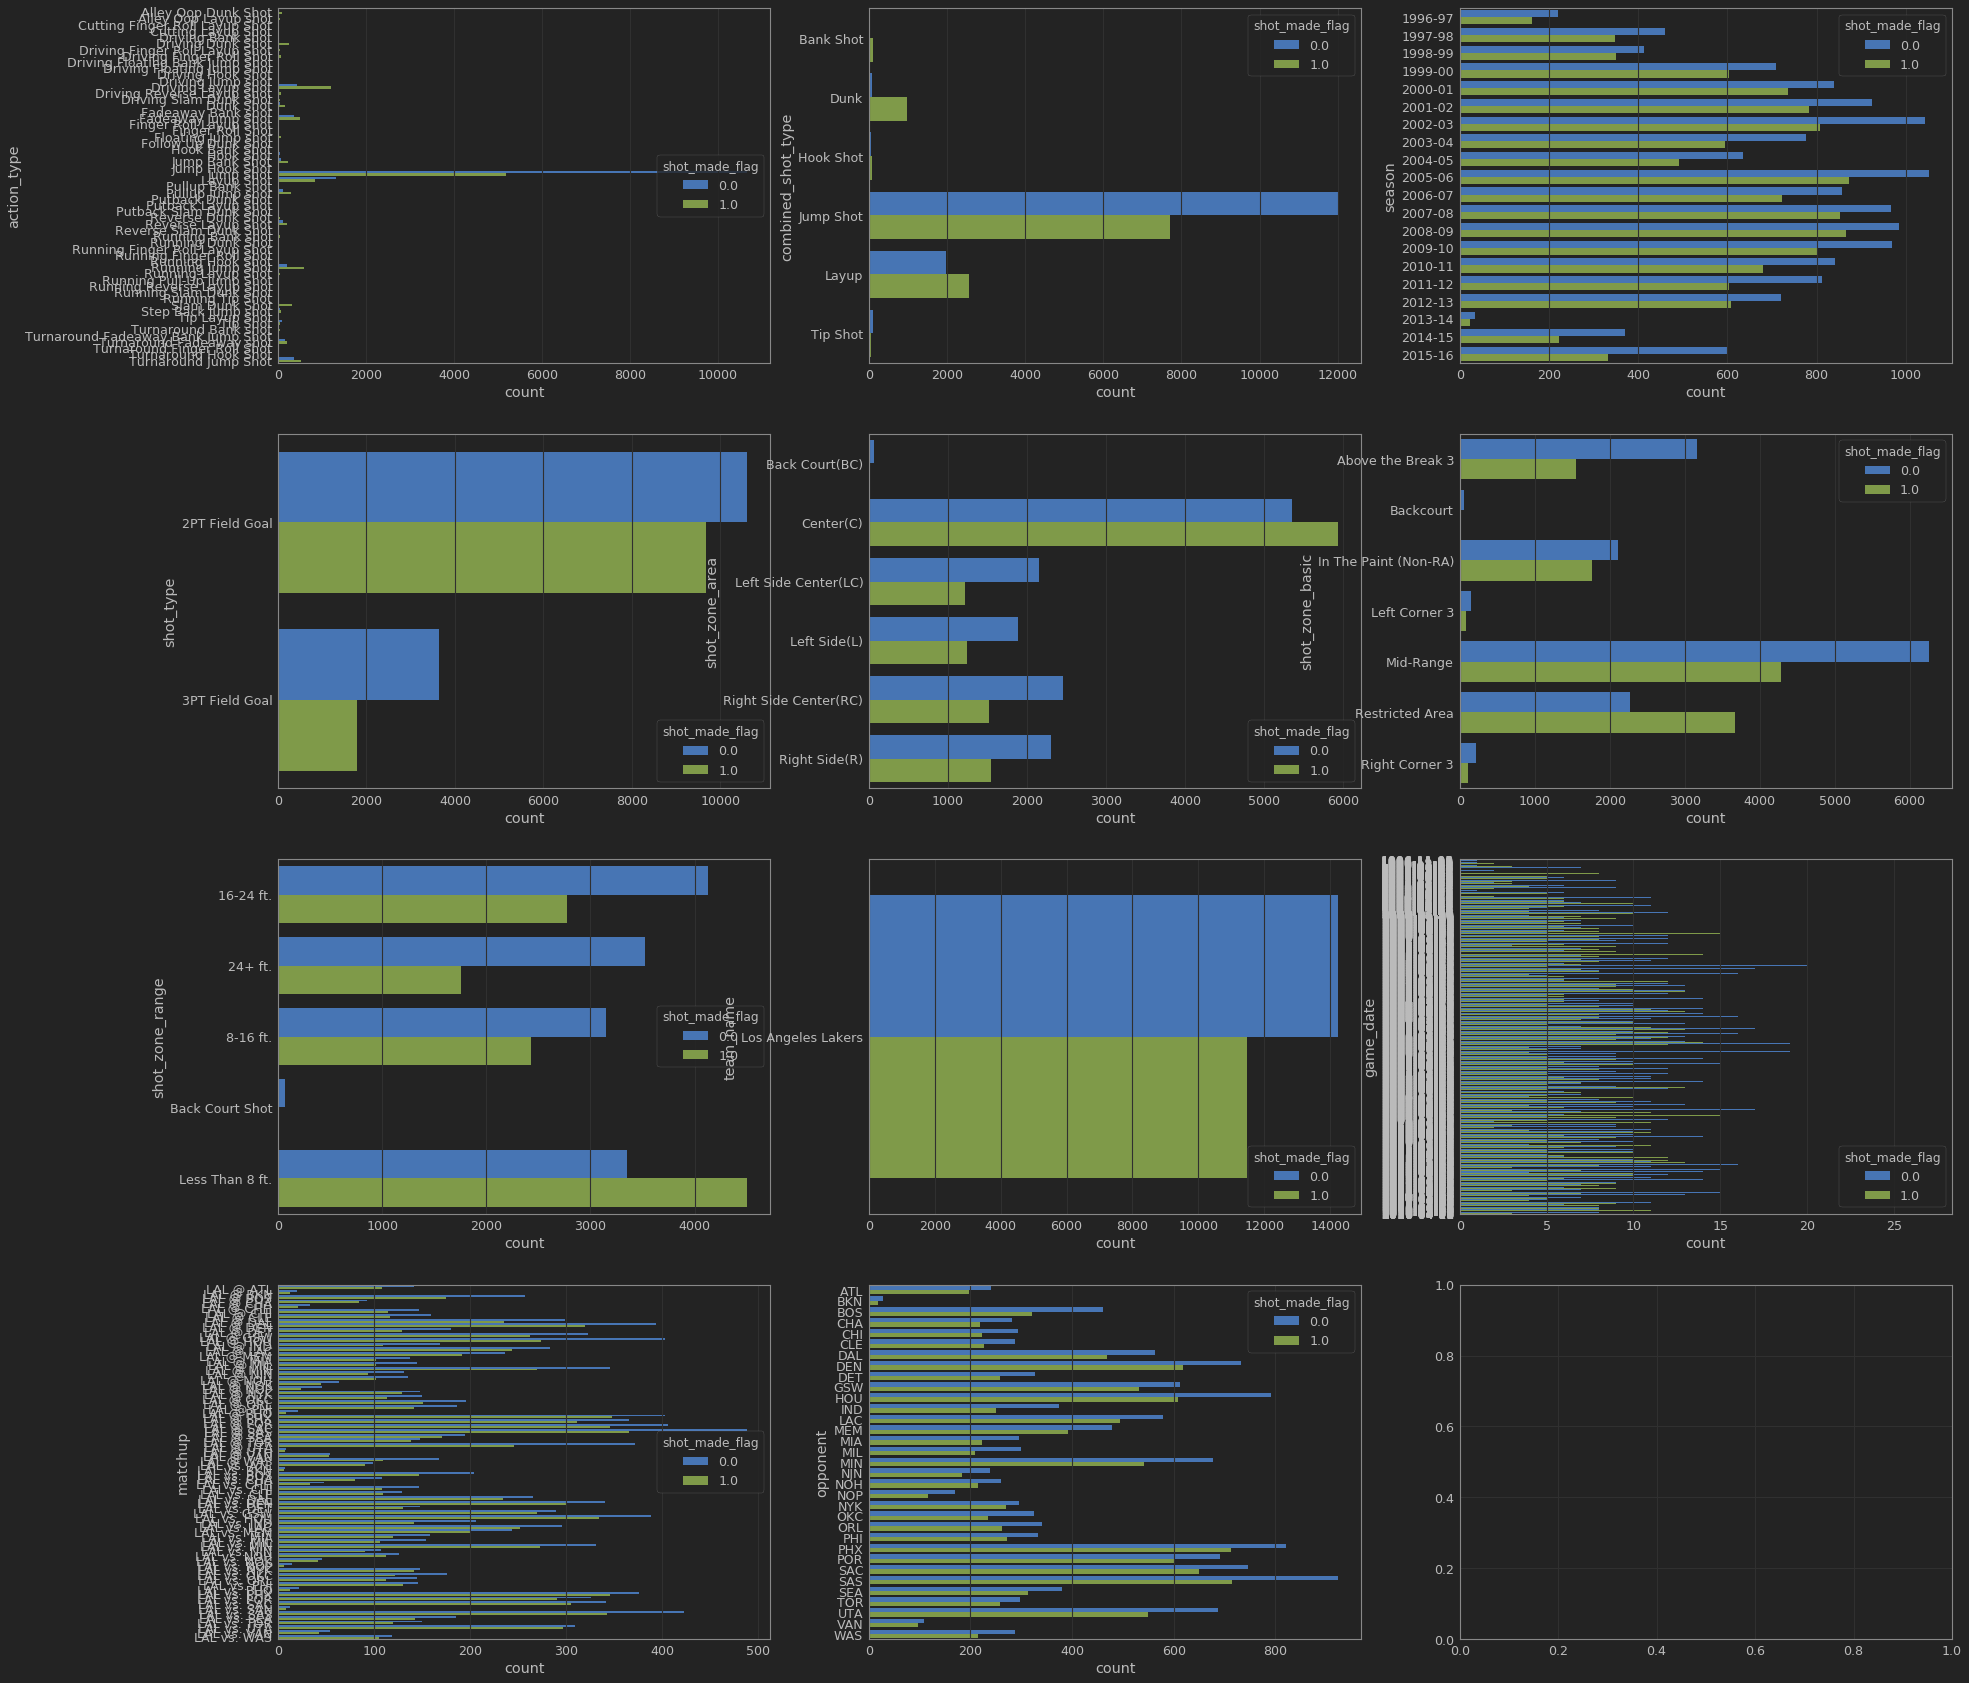

In [5]:
fig, ax = plt.subplots(ncols=3,nrows=ceil(len(categorical.columns)/3),figsize=(30,30))
for col,ax in zip(categorical.columns,chain(*ax)):
    sns.countplot(data=data,y=col,hue=target,ax=ax)

## Numerical

In [48]:
numerical = data.select_dtypes(include=[np.number])
numerical.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09


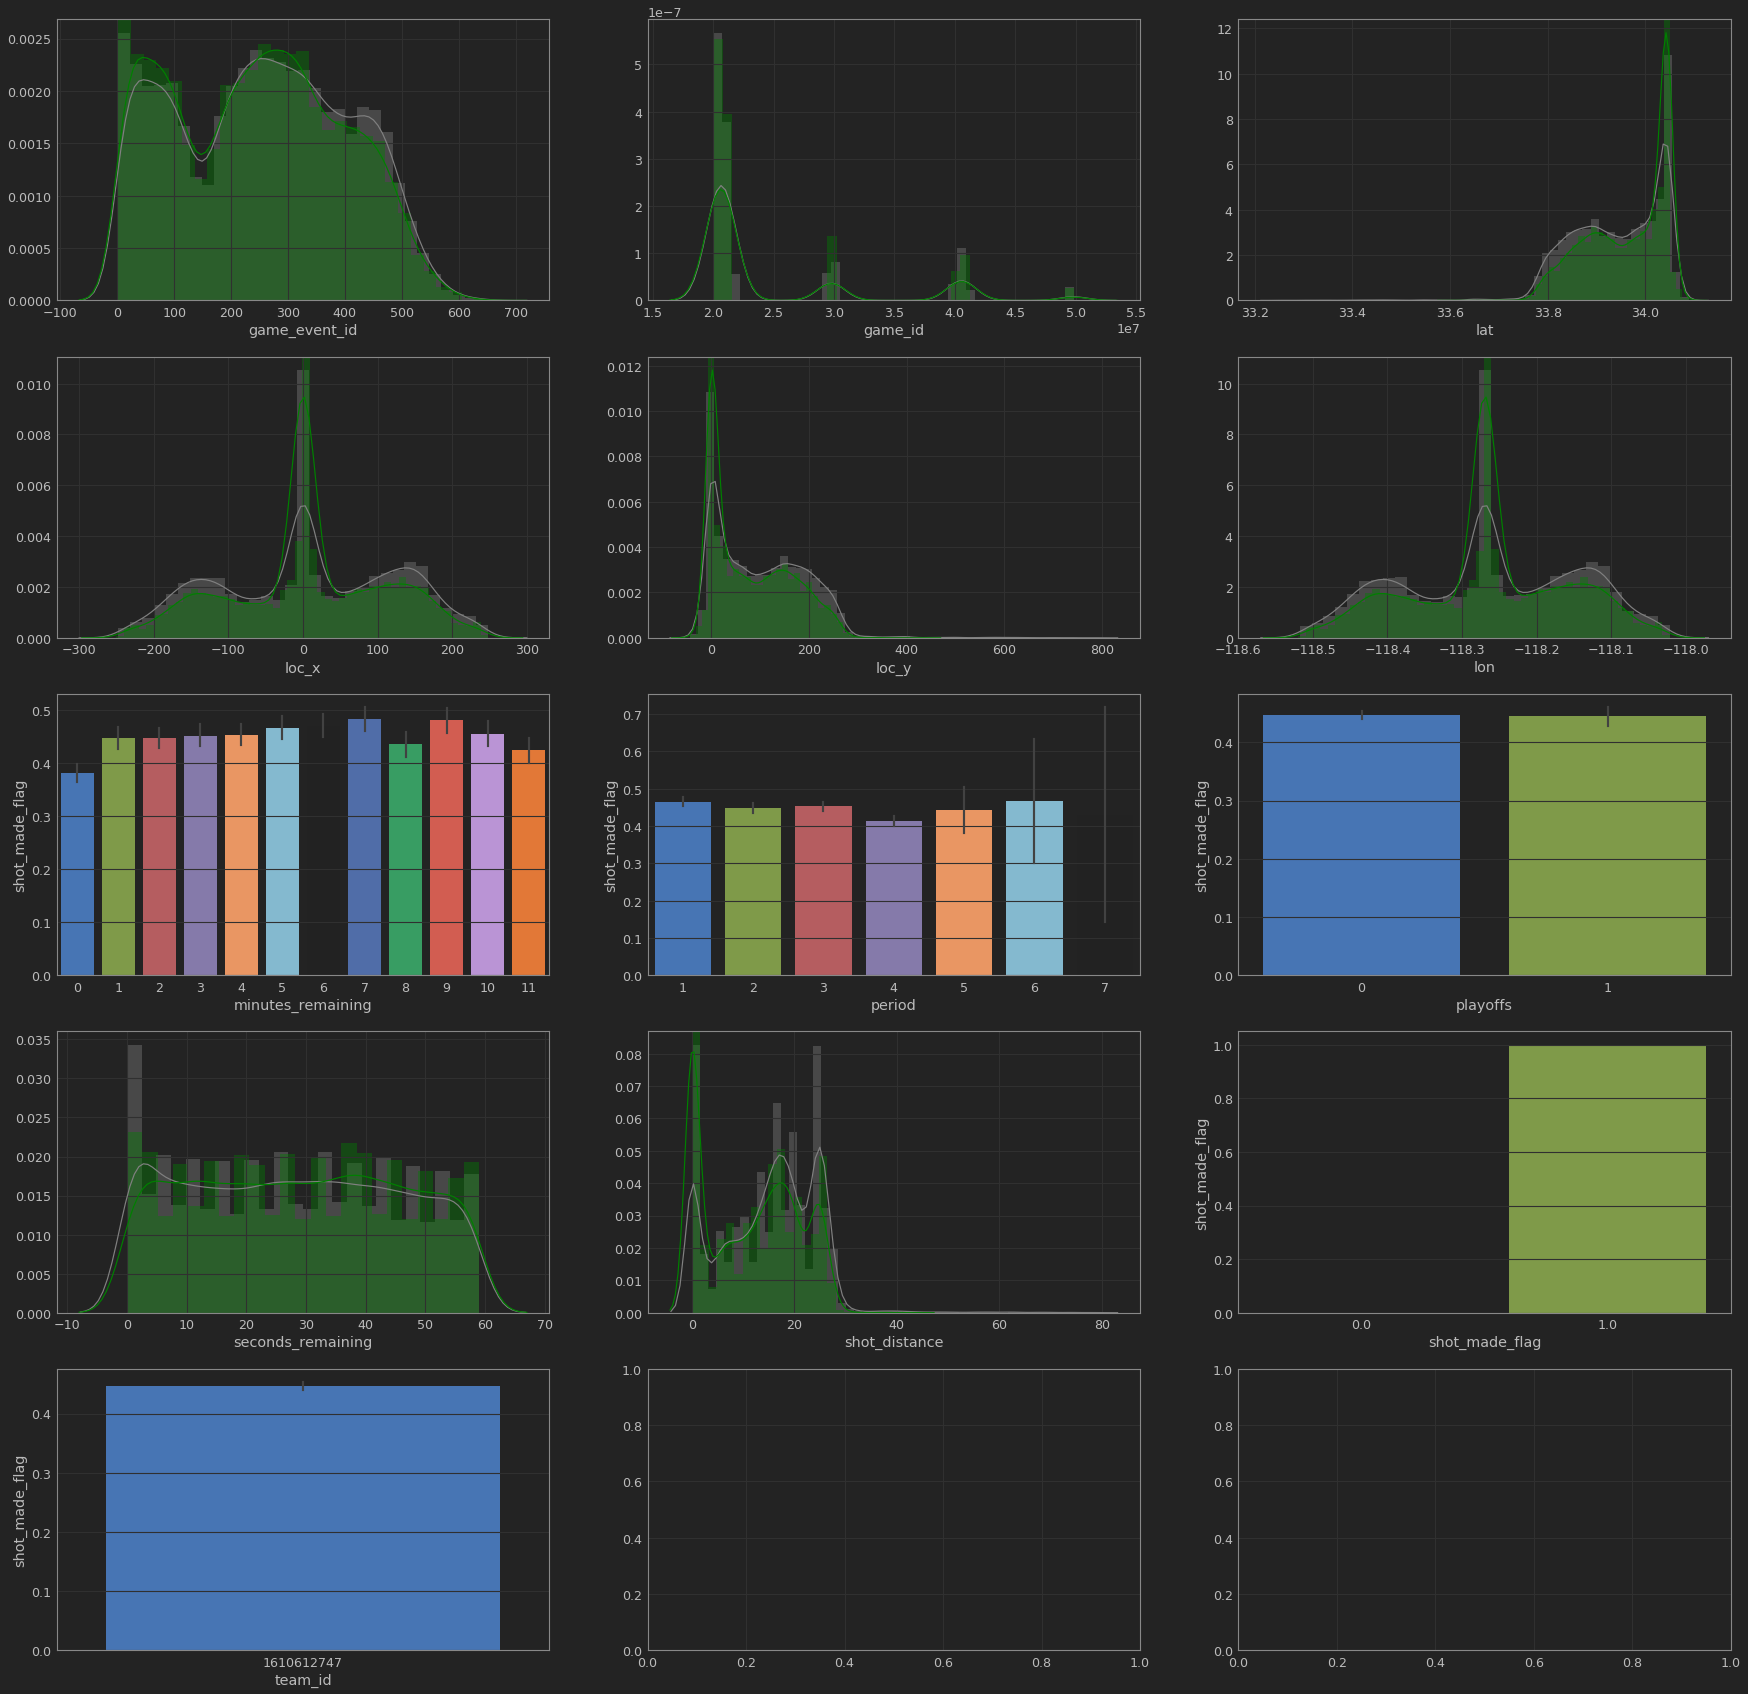

In [47]:
fig, ax = plt.subplots(ncols=3,nrows=ceil(len(numerical.columns)/3),figsize=(30,30))
for col,ax in zip(numerical.columns,chain(*ax)):
    if len(data[col].unique())<60:
        sns.factorplot(data=data,x=col,y='shot_made_flag',ax=ax,kind='bar')
        plt.close(2)
    else:
        g=sns.distplot(data[data[target]==0][col],ax=ax,color='grey')
        sns.distplot(data[data[target]==1][col],color='green',ax=ax)

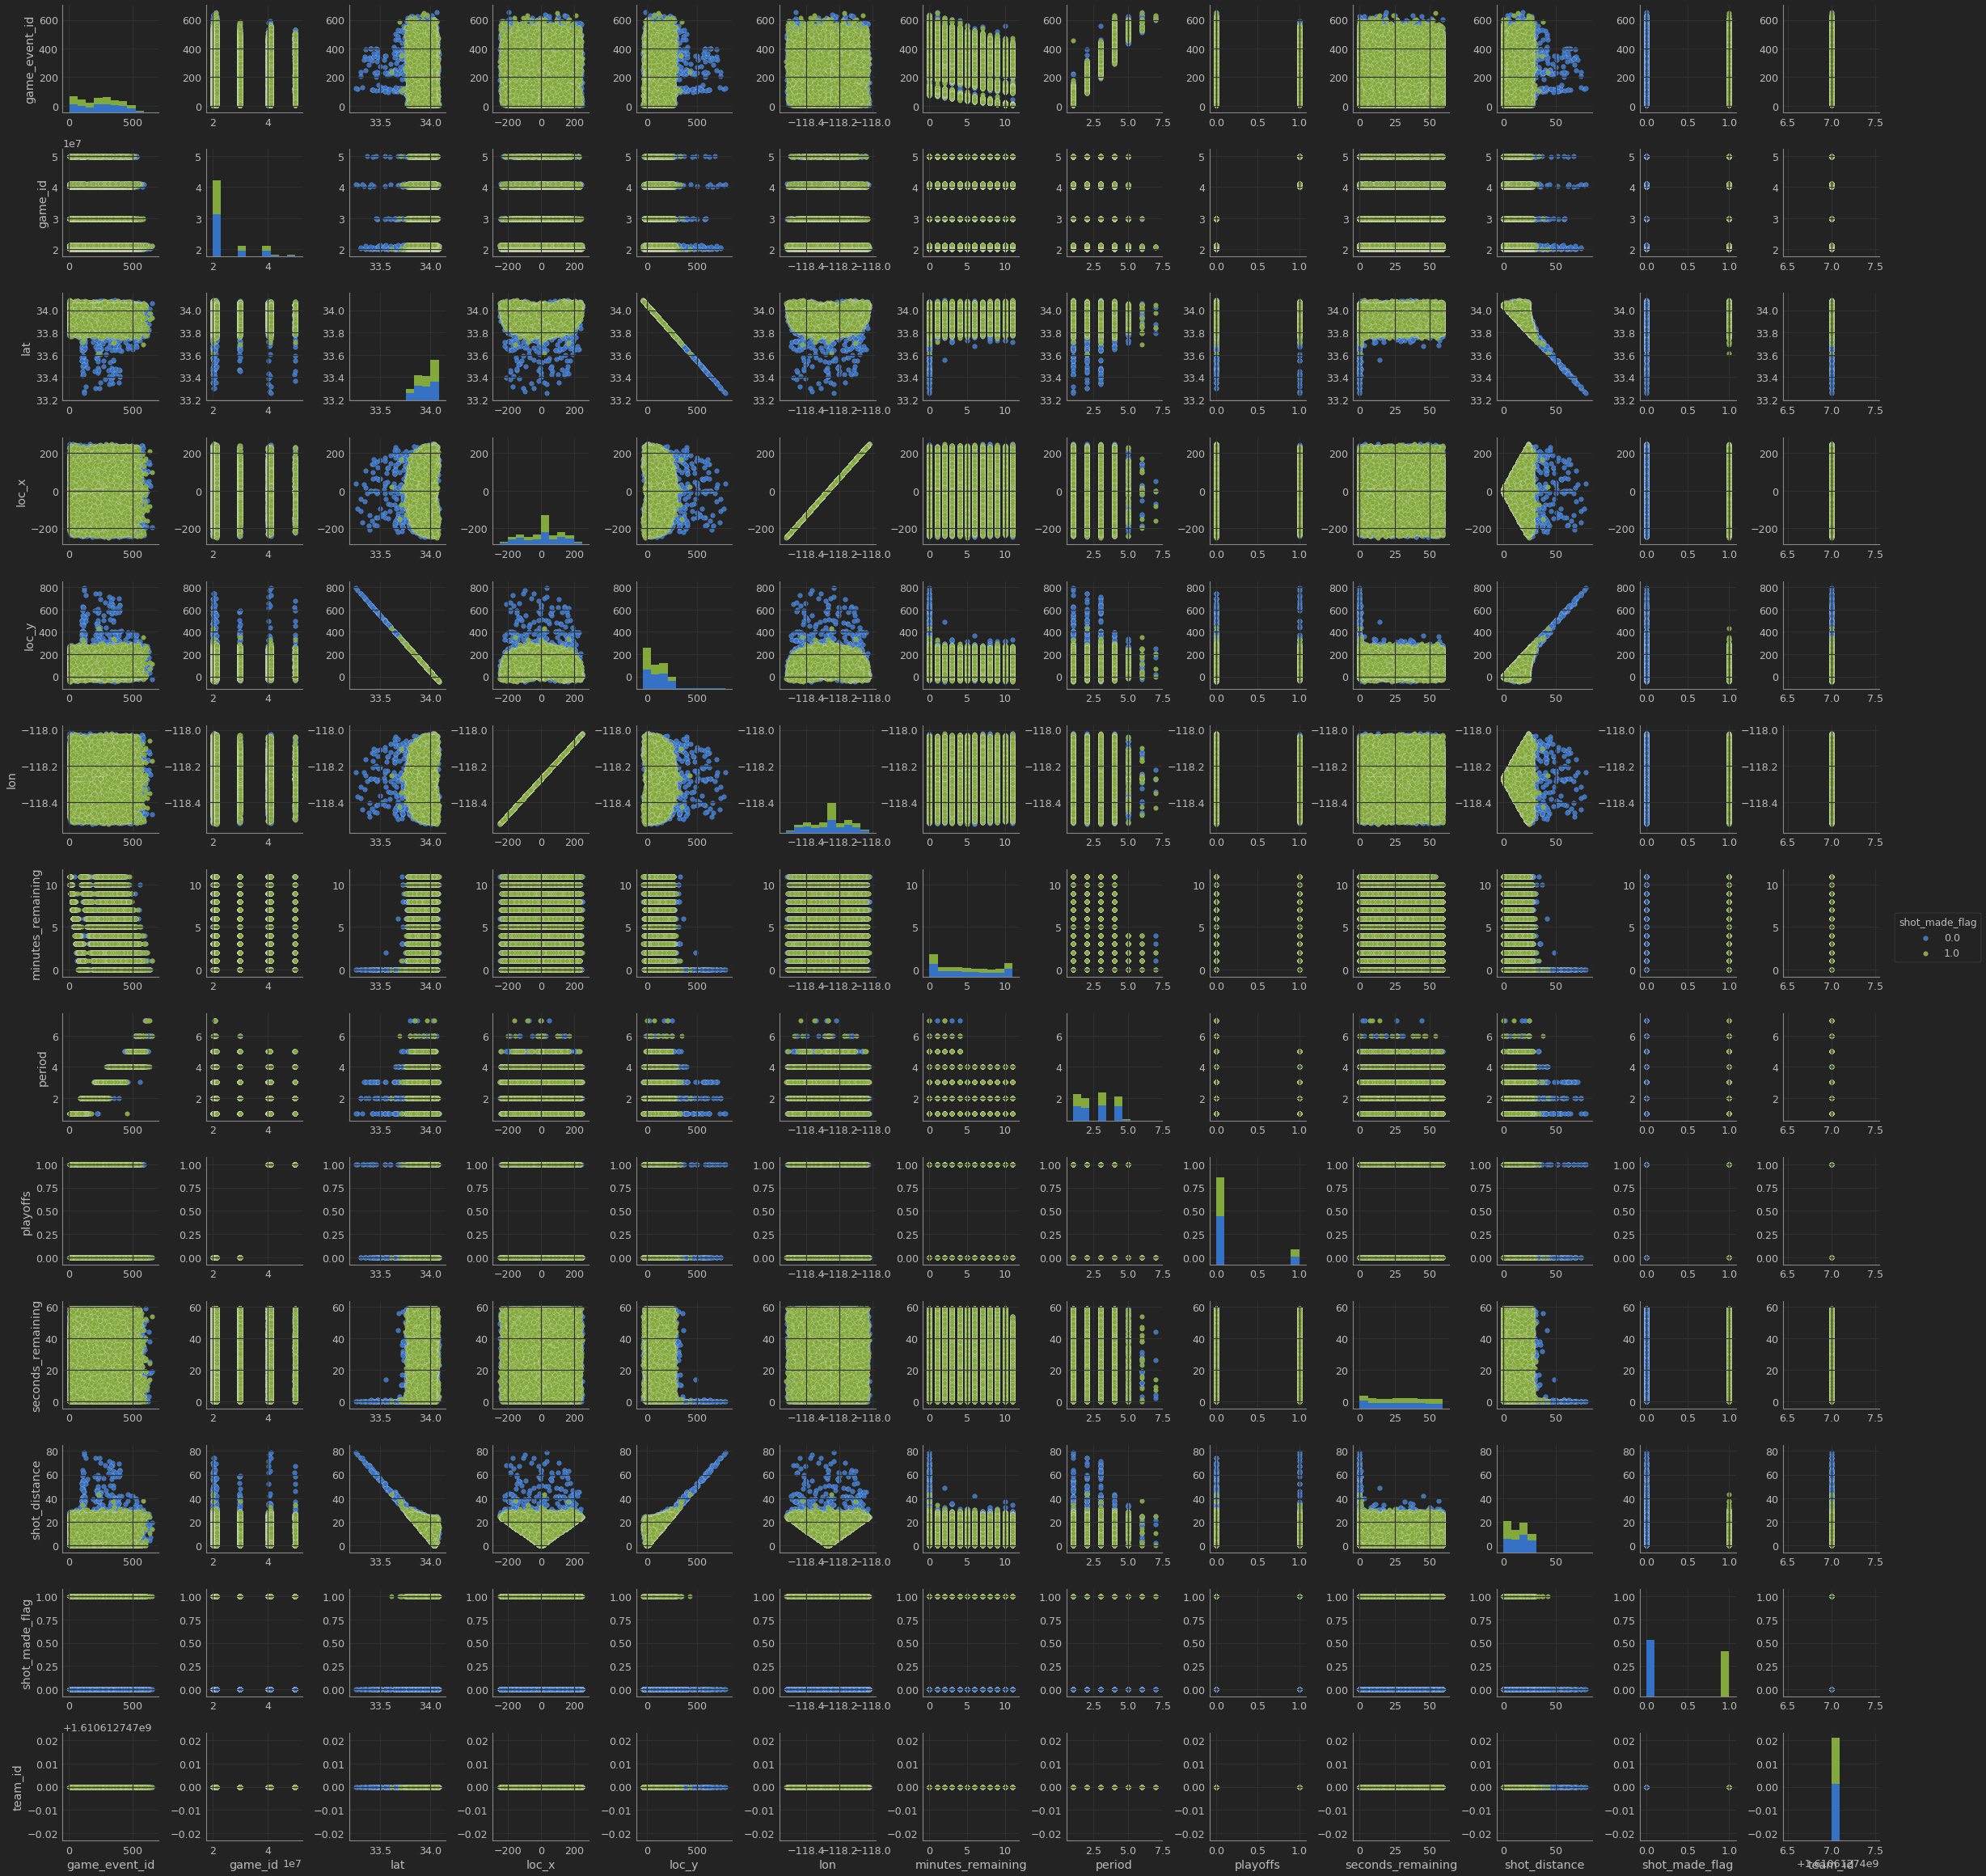

In [8]:
sns.pairplot(data, hue=target, vars=numerical)
